In [2]:
import pandas as pd
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [3]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [61]:
G = StellarGraph(df_features, df_patients)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 597, Edges: 177904

 Node types:
  default: [597]
    Features: float32 vector, length 100
    Edge types: default-default->default

 Edge types:
    default-default->default: [177904]
        Weights: range=[0.718296, 0.99577], mean=0.93189, std=0.0322031
        Features: none


In [62]:
# Splitting data into train/validation/test

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

series_classes = df_classes['class']

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  447
Len validation:  90
Len test:  60

Len everything:  597


In [63]:
from collections import Counter
Counter(train_subjects)

Counter({'stage1': 198,
         'control': 54,
         'stage4': 62,
         'stage3': 91,
         'stage2': 42})

In [64]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [65]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [66]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [67]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [68]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [69]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/100
1/1 - 3s - loss: 13.8161 - acc: 0.1365 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 2/100
1/1 - 1s - loss: 13.3165 - acc: 0.1678 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 3/100
1/1 - 1s - loss: 7.5485 - acc: 0.1499 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 4/100
1/1 - 1s - loss: 12.5441 - acc: 0.1924 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 5/100
1/1 - 1s - loss: 14.1332 - acc: 0.1208 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 6/100
1/1 - 1s - loss: 13.4989 - acc: 0.1611 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 7/100
1/1 - 1s - loss: 10.4463 - acc: 0.2036 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 8/100
1/1 - 1s - loss: 13.4217 - acc: 0.1611 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 9/100
1/1 - 1s - loss: 11.6831 - acc: 0.1700 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 10/100
1/1 - 1s - loss: 13.2974 - acc: 0.1320 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 11/100
1/1 - 1s - loss: 13.4716 - acc: 0.1409 - val_loss: 14.1481 - val_acc: 0.1222
Epoch 12/100
1/1 - 1

Epoch 93/100
1/1 - 1s - loss: 7.2594 - acc: 0.3468 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 94/100
1/1 - 1s - loss: 12.6926 - acc: 0.2125 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 95/100
1/1 - 1s - loss: 8.1824 - acc: 0.2371 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 96/100
1/1 - 1s - loss: 10.4639 - acc: 0.2304 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 97/100
1/1 - 1s - loss: 12.8247 - acc: 0.1790 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 98/100
1/1 - 1s - loss: 12.2231 - acc: 0.1857 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 99/100
1/1 - 1s - loss: 13.6449 - acc: 0.1432 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 100/100
1/1 - 1s - loss: 12.7684 - acc: 0.2081 - val_loss: 8.9545 - val_acc: 0.4444


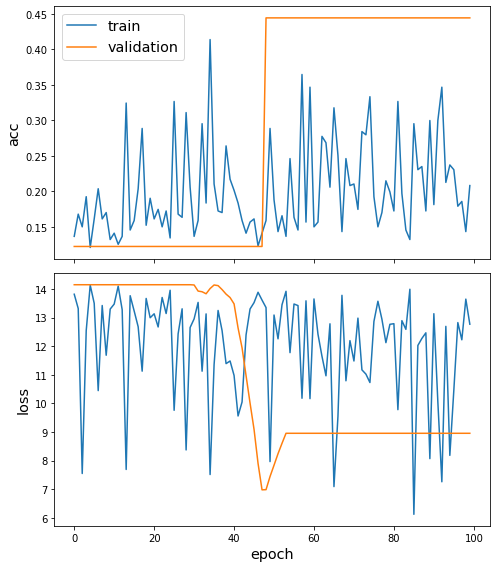

In [70]:
sg.utils.plot_history(history)

In [71]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 153ms/step - loss: 7.2555 - acc: 0.4333

Test Set Metrics:
	loss: 7.2555
	acc: 0.4333


In [72]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [73]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})
df.head(20)

,Predicted,True
id,,
TCGA.B8.4151.01,stage1,stage3
TCGA.B0.5699.01,stage1,stage1
TCGA.CZ.5989.01,stage1,stage2
TCGA.BP.4795.01,stage1,stage1
TCGA.B0.5096.01,stage1,stage3
TCGA.B2.5641.11,stage1,control
TCGA.A3.3329.01,stage1,stage1
TCGA.CJ.6031.01,stage1,stage1
TCGA.B4.5834.01,stage1,stage1
